In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import scipy

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

#from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.listdir("/content/drive/My Drive/Colab Notebooks/TaiwanTree")

['liddar_img_v1.csv', 'all']

In [4]:
import os
path = '/content/drive/My Drive/Colab Notebooks/TaiwanTree/all/'
count = 0
for root,dirs,files in os.walk(path):
      for each in files:
          if each.endswith('png'):
             count += 1
print ("圖片數量：",count)

圖片數量： 54425


# 1. Data Exploration

In [72]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/TaiwanTree/liddar_img_v1.csv")
df.head(3)

,id,area,image,valid_count,valid_count_zero,is_finished,update_t,Label
0,3094,1,9621-1-006_001.png,1,3,1,2020/12/23 12:21,N
1,1427,1,9621-1-006_002.png,0,3,1,2020/12/23 12:21,N
2,4814,1,9621-1-006_003.png,3,2,1,2020/12/23 12:21,Y


In [73]:
toy=False
if toy:
    all = all.sample(50000)
df.head(3)

,id,area,image,valid_count,valid_count_zero,is_finished,update_t,Label
0,3094,1,9621-1-006_001.png,1,3,1,2020/12/23 12:21,N
1,1427,1,9621-1-006_002.png,0,3,1,2020/12/23 12:21,N
2,4814,1,9621-1-006_003.png,3,2,1,2020/12/23 12:21,Y


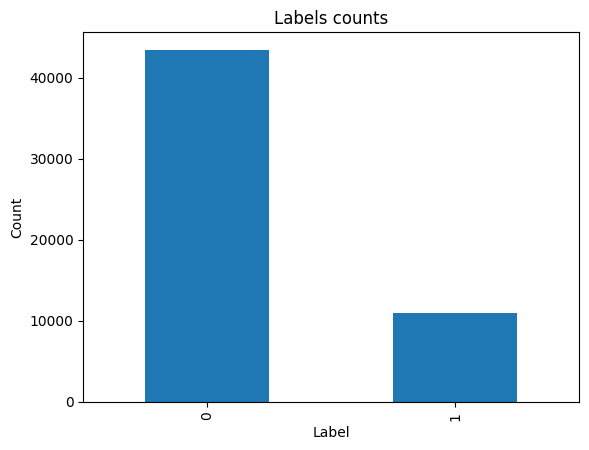

In [56]:
df.Label.value_counts().plot(kind='bar')
plt.style.use('fast')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [10]:
class ImageViewer:
    def read_img(self,id):
        """
        Read image by it's id
        """
        file='/content/drive/My Drive/Colab Notebooks/TaiwanTree/all/'+ str(id)
        im=cv2.imread(file)
        return im

    def draw_sample_images(self):
        """
        Draw cancer and healthy images for EDA
        """
        ncols=4
        plt.style.use('default')
        f, ax = plt.subplots(nrows=2,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=['N', 'Y']
        # Draw one row for cancer, one row for healthy images
        for label in ['N','Y']:
            i=i+1
            samples = df[df['Label']==label]['image'].sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

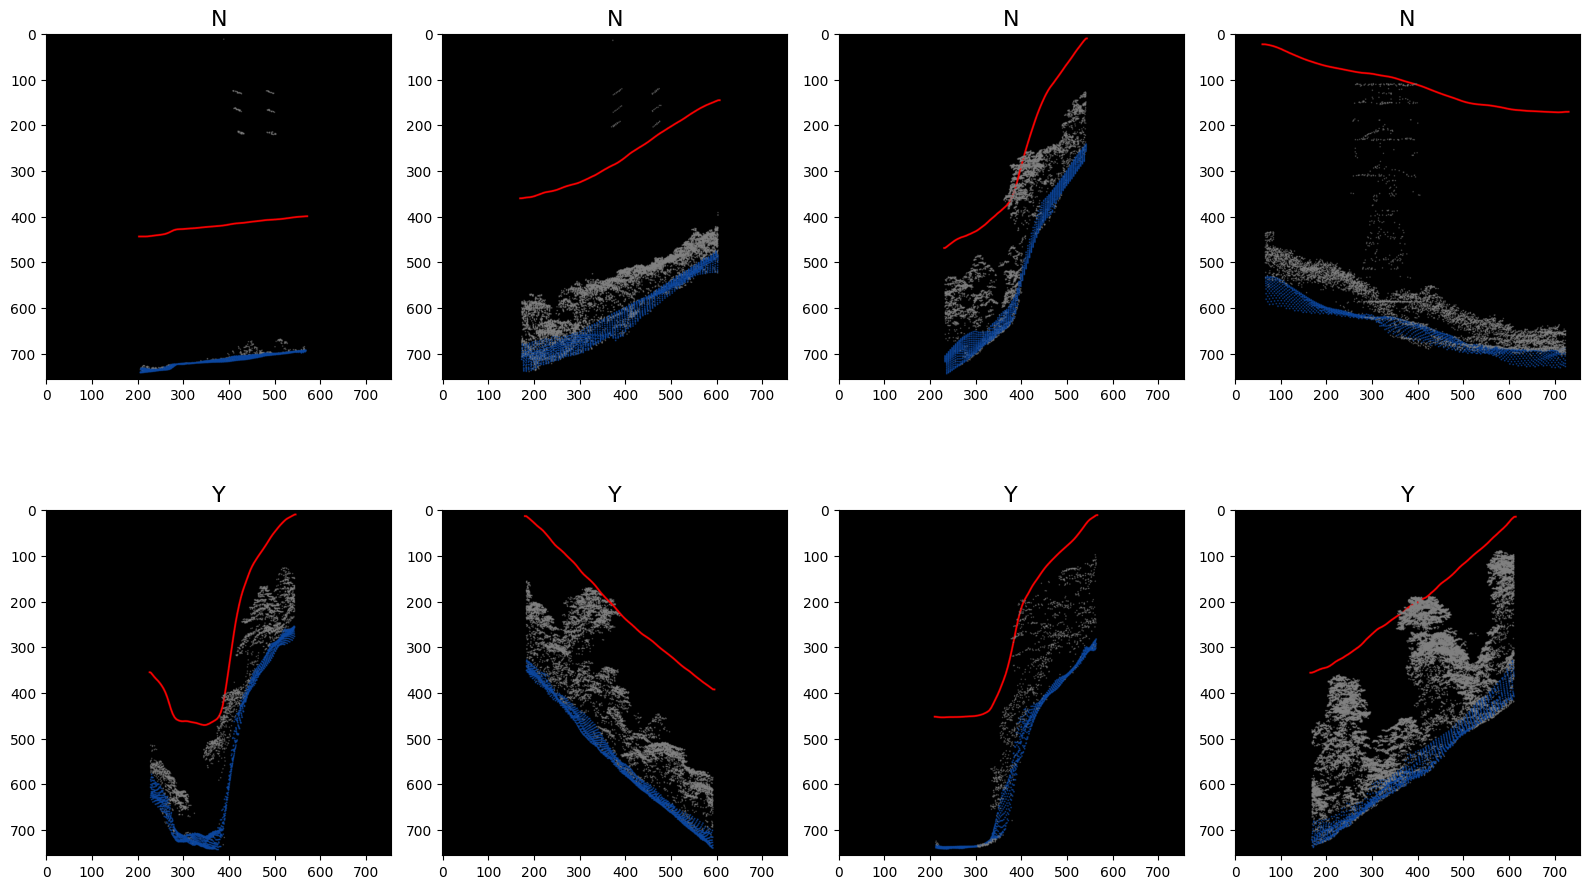

In [11]:
ImageViewer().draw_sample_images()

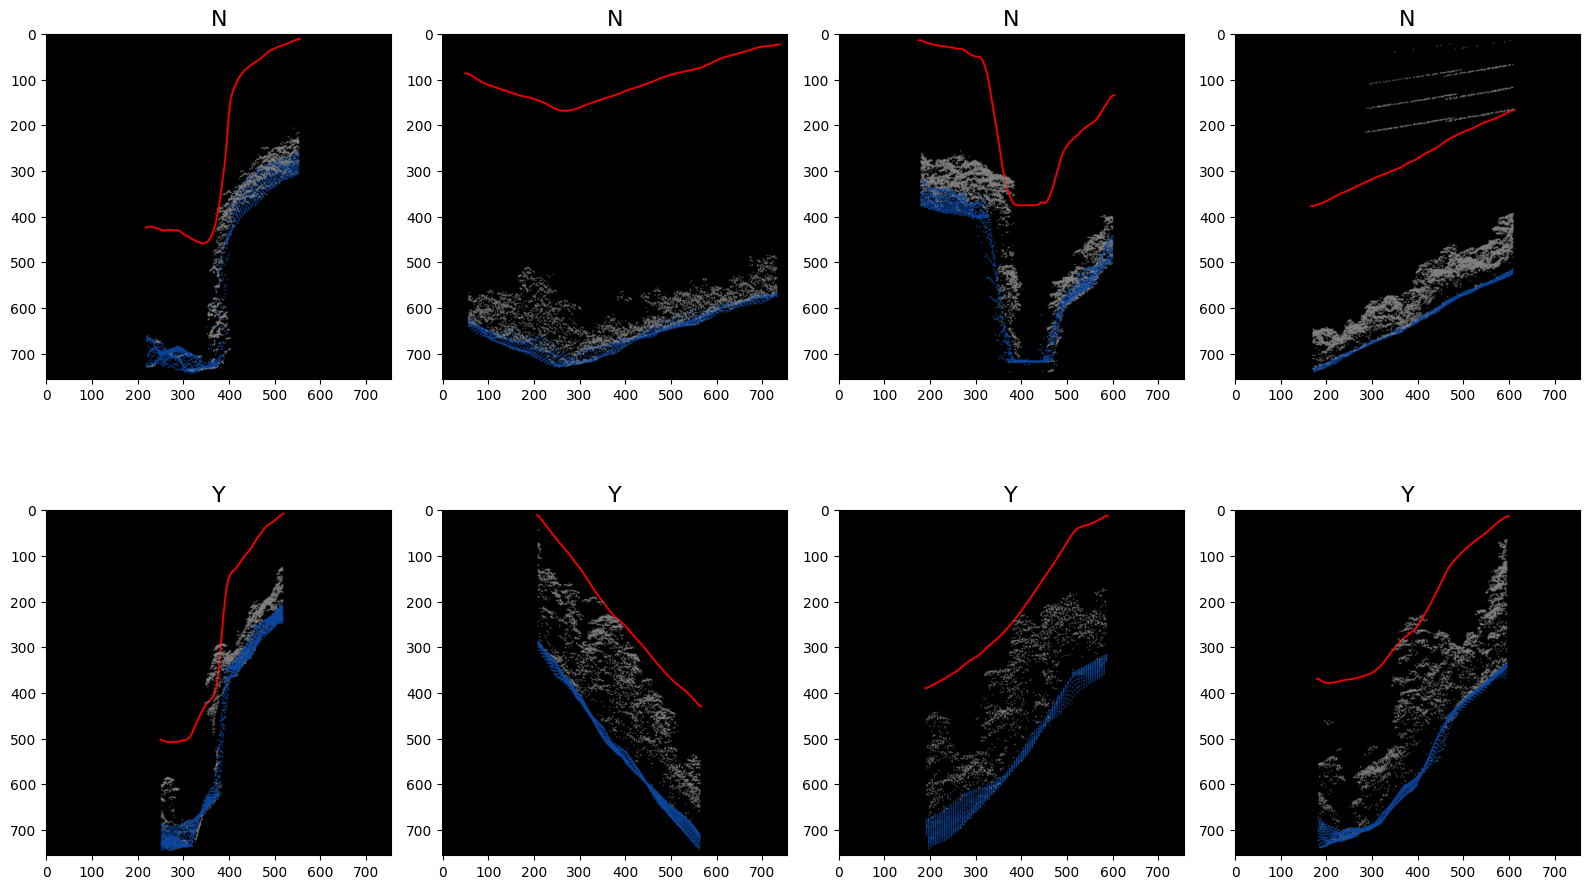

In [12]:
ImageViewer().draw_sample_images()

# 2. Data Preprocess
Here we are going to balance dataset and prepare image generator

In [57]:
class DataPreparation:
    """
    Train/test
    """
    def train_test_split(self, all_df):
        """
        Balanced split to train, test and val
        """
        # Split to train and test before balancing
        train_df, test_df = train_test_split(df, random_state=24)
#         # Split train to train and validation datasets
#         train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=24)
        # Number of samples in each category
        ncat_bal = df['Label'].value_counts().max()
        #ncat_bal = int(len(train_df)/train_df['label'].cat.categories.size)
        train_df = train_df.groupby('Label', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        return train_df, test_df
    
    def plot_balanced(self, train_df, df):
        """
        Plot samples per category before and after balancing
        """
        f, axs = plt.subplots(1,2,figsize=(12,4))
        # Before balancing
        df.Label.value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('Label')
        axs[0].set_ylabel('Count')
        # After balancing
        train_df.Label.value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels after balancing')
        axs[1].set_xlabel('Label')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()

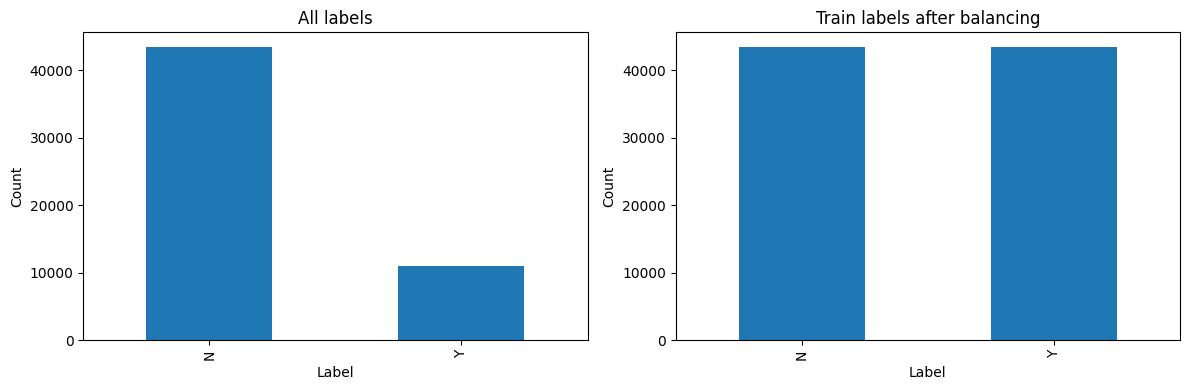

In [119]:
# Train/test/validation split with balanced labels in train
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(df)

# Plot before and after balancing
data_prep.plot_balanced(train_df, df)

In [117]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size=32
        self.img_size=(64,64)
        
        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="/content/drive/My Drive/Colab Notebooks/TaiwanTree/all/",
            x_col="image",
            y_col="Label",
            has_ext=False,
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="/content/drive/My Drive/Colab Notebooks/TaiwanTree/all/",
            x_col="image",
            y_col="Label",
            has_ext=False,
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="/content/drive/My Drive/Colab Notebooks/TaiwanTree/all/",
            x_col="image",
            y_col='Label',
            has_ext=False,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')

In [118]:
# Create generators        
generators = Generators(train_df, test_df)
print("Generators created")

Found 65154 validated image filenames belonging to 2 classes.
Train generator created
Found 21718 validated image filenames belonging to 2 classes.
Validation generator created
Found 13604 validated image filenames belonging to 2 classes.
Test generator created
Generators created


# 3. Model Training

In [17]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

In [120]:
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model_small(self):
        """
        Build CNN model using img_width, img_height from fields.
        """
        model=Sequential()
        model.add(Conv2D(16, kernel_size=3, input_shape=(self.img_width, self.img_height,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
        model.add(Dropout(0.1))
        model.add(Flatten())
        model.add(Dense(64, activation = "relu"))        
        # 1 y label
        model.add(Dense(2, activation='softmax'))
        model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def create_model(self,
                    kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 32,
                    second_filters = 64,
                    third_filters = 128,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.3):

        model = Sequential()
        # First conv filters
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding="same",
                         input_shape = (self.img_width, self.img_height,3)))
        model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        # Second conv filter
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        # Third conv filter
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        
        # First dense
        model.add(Dense(first_dense, activation = "relu"))
        model.add(Dropout(dropout_dense))
        # Second dense
        model.add(Dense(second_dense, activation = "relu"))
        model.add(Dropout(dropout_dense))
        
        # Out layer
        model.add(Dense(2, activation = "softmax"))

        model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        return model
        
    
    def train(self, model, toy):
        """
        Train the model
        """
        if toy:
            epochs=3
            steps_per_epoch=20
            validation_steps=2
        else:
            epochs=50
            steps_per_epoch=50
            #steps_per_epoch=30
            #steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_acc'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=[earlystopper, checkpointer, reduce_lr])
        # Get the best saved weights
        #model.load_weights('best_model1.h5')
        return training

In [121]:
# Create and train the model
trainer = ModelTrainer(generators)

In [122]:
model = trainer.create_model(kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 128,
                    second_filters = 256,
                    third_filters = 512,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.2)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 256)      

In [123]:
training=trainer.train(model,toy)
print("Trained")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 34s 664ms/step - loss: 0.6685 - accuracy: 0.6225 - val_loss: 1.1280 - val_accuracy: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 43s 873ms/step - loss: 0.6099 - accuracy: 0.6744 - val_loss: 1.6958 - val_accuracy: 0.0562
Epoch 3/50
50/50 [==============================] - 48s 955ms/step - loss: 0.5580 - accuracy: 0.7126 - val_loss: 0.8349 - val_accuracy: 0.5312
Epoch 4/50
50/50 [==============================] - 42s 851ms/step - loss: 0.4951 - accuracy: 0.7554 - val_loss: 0.8937 - val_accuracy: 0.2750
Epoch 5/50
50/50 [==============================] - 51s 1s/step - loss: 0.4955 - accuracy: 0.7662 - val_loss: 0.8793 - val_accuracy: 0.4812
Epoch 6/50
50/50 [==============================] - 40s 805ms/step - loss: 0.4268 - accuracy: 0.8070 - val_loss: 1.1695 - val_accuracy: 0.4000
Epoch 7/50
50/50 [==============================] - 44s 892ms/step - loss: 0.4326 - accuracy: 0.8042 - val_loss: 0.6258 - val_accuracy: 0.718

In [124]:
#model.load_weights('best_model1.h5')
model.save('model.h5')

# 4. Test

In [125]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator
        # predict the data
        steps=5
        self.y_pred_raw = model.predict_generator(self.generator, steps=steps)
        self.y_pred = np.argmax(self.y_pred_raw, axis=1)
        self.y_true=y_true[:len(self.y_pred)]
        self.y_true = np.where(self.y_true=='N', 0, self.y_true)
        self.y_true = np.where(self.y_true=='Y', 1, self.y_true)        
    
    """
    Accuracy, evaluation
    """
    def plot_history(self):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['accuracy'], label="Accuracy")
        ax[1].plot(self.training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    
    def plot_roc(self):
        #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        print(metrics.classification_report(self.y_true, self.y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


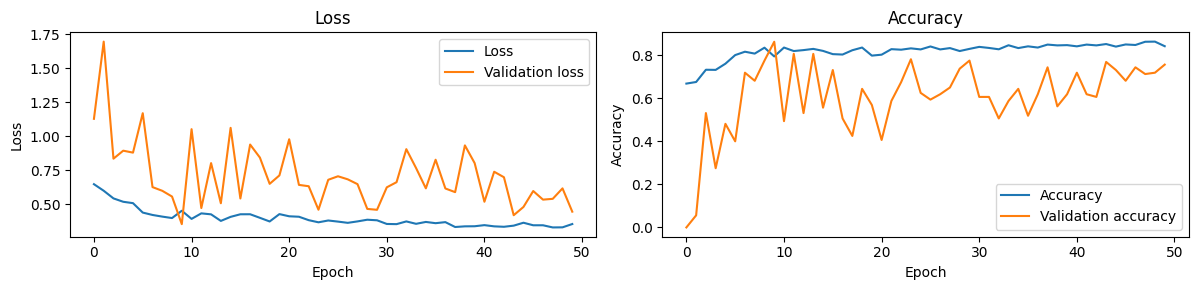

In [126]:
# Create evaluator instance
evaluator = Evaluator(model, training, generators.test_generator, test_df.Label.values)

# Draw accuracy and loss charts
evaluator.plot_history()

In [127]:
steps=5
#generators.test_generator
y_pred_raw = model.predict_generator(generators.test_generator, steps=steps)
y_pred = np.argmax(y_pred_raw, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [128]:
y_pred

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1])

In [129]:
y_true=test_df.Label.values
y_true

array(['N', 'N', 'Y', ..., 'N', 'Y', 'N'], dtype=object)

In [130]:
y_true=y_true[:len(y_pred)]

In [131]:
y_true = np.where(y_true=='N', 0, y_true)
y_true = np.where(y_true=='Y', 1, y_true)

In [111]:
def performance_model(prediction,y_test):
    # Get Label in array
    list = []
    for i in y_test:
        list.append(i)
    arr = np.arange(len(y_test)).reshape(len(y_test),1)
    np.place(arr, arr>=0, list)
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if prediction[i] == arr[i]:
            if prediction[i] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if prediction[i] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    return(ACC,PR,RC,FS)

In [132]:
ACC,PR,RC,FS = performance_model(y_pred,y_true)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.7375
Precision: 0.38461538461538464
Recall:  0.9259259259259259
F-score:  0.5434782608695653
